# Gaussian Mixture Model
Hasti Hojabr \
ID : 97216040\
Proffesor: Marzie Farhang\
Course: Statics, Probability and Data Analysis @ Shahid Beheshti University \
Date: June 8,2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [20]:
import mglearn
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from matplotlib.pyplot import cm
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

## 3 Applications

In [54]:
def GMM_ND(X,k,iterations,check,radius):
    
    def Expectation(X,means,variances): 
        r = [] ; r_norm=[] ;     cc = 1e-6*np.identity(len(X[0]))

        for i in range(k): 
            if covs[i,0,0]==0 or covs[i,1,1]==0: covs[i,0,0] = 1e-5 ; covs[i,1,1] = 1e-5 

            r.append(multivariate_normal.pdf(X, means[i],covs[i]))

        r = np.array(r)  
        for j in range(k): r_norm.append((r[j])/(np.sum([r[i] for i in range(k)], axis=0)))

        return np.array(r_norm),np.sum([r[i] for i in range(k)], axis=0)  #responsibility r_nk, likelihood


    def Maximization(r,means,variances,pi):

        for i in range(k):
            Nk       = np.sum(r[i,:],axis=0)        # Σ r_nk
            m        = r[i,:].reshape(len(X),1) *X 
            means[i] = np.sum(r[i,:].reshape(len(X),1) *X,axis=0)/Nk          # 1/Nk Σ r_nk * x_n
            pi[i]    = Nk/len(X)                    # Nk/N
            covs[i]  = (np.dot(np.transpose(r[i,:].reshape(len(X),1)*(X-means[i])),(X-means[i])))/Nk  # 1/Nk Σ r_nk * (x_n-mean_k).(x_n-mean_k)^T
        return means,covs,pi


    def Principal_axes(pos,cov):
        U, S, Vt = np.linalg.svd(cov)   #Cov = US(V^T)  S contains eigenvalues

        #print('Not Diag Form',covariance)
        #print('********')
        #print('Diag Form',U*np.diag(S)*Vt)

        width, height = 2 * np.sqrt(S)
        angle = np.arctan2(U[1, 0], U[0, 0]) * 180/np.pi

        return width, height,angle

    def Gaussian_plot(X,means,covariances,pis,radius,ax):

        
        c = cm.winter(np.linspace(0, 1, len(pis))) #colors
        
        for loc, cov,color in zip(means,covariances,c):
            width,height,angle = Principal_axes(loc,cov)

            for i in radius: ax.add_patch(Ellipse(loc, i*width, i*height, angle,
                                                      alpha=0.2,color=color)) 
        ax.scatter(X[:, 0], X[:, 1],color='k',marker='.')

    #Initialize the hidden variables
    means = np.random.uniform(np.min(X),np.max(X),size=(k,2))
    covs  = np.array([np.identity(2).tolist() for n in range(k)])
    pi    = np.repeat(1/k,k)

    fig = plt.figure(figsize=(18, 8))
    log_likelihood = np.zeros(iterations)
    axis=1
    for iterr in range(iterations):

        r,likelihood  = Expectation(X,means,covs)       #E step
        means,covs,pi = Maximization(r,means,covs,pi)   #M step

        log_likelihood[iterr] = np.log(np.sum(likelihood)) #Log of likelihood. Its used for convergence. 

        if iterr in [0,2,(iterations-1)//2,iterations-1]: 
            
            ax =  fig.add_subplot(2, 2, axis )
            Gaussian_plot(X,means,covs,pi,radius,ax)
            plt.title('Iteration {}/{}'.format(iterr,iterations-1))
            axis+=1
        
    return means,covs,log_likelihood,pi


In [50]:
def Principal_axes(pos,cov):
    U, S, Vt = np.linalg.svd(cov)   #Cov = US(V^T)  S contains eigenvalues

    #print('Not Diag Form',covariance)
    #print('********')
    #print('Diag Form',U*np.diag(S)*Vt)
    
    width, height = 2 * np.sqrt(S)
    angle = np.arctan2(U[1, 0], U[0, 0]) * 180/np.pi

    return width, height,angle

def Gaussian_plot(X,labels,means,covariances,pis,radius,ax):

    ax = ax

    c = cm.winter(np.linspace(0, 1, len(pis))) #colors
    
    if type(X)==pd.core.frame.DataFrame:
        mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], labels, s=7, markers='.',c=c)
    else: 
        mglearn.discrete_scatter(X[:, 0], X[:, 1], labels, s=7, markers='.',c=c)
    for loc, cov,color in zip(means,covariances,c):
        width,height,angle = Principal_axes(loc,cov)

        for i in radius: ax.add_patch(Ellipse(loc, i*width, i*height, angle,
                                                  alpha=0.2,color=color)) 
    plt.title('GMM for {} clusters.'.format(len(means)))
        

In [17]:
from sklearn.mixture import GaussianMixture  

def GMM_sklearn_Nd(x,k,iterations):
    
    GMM = GaussianMixture(n_components = k, max_iter=iterations, random_state=10, covariance_type = 'full')
    
    means = GMM.fit(x).means_  
    covs  = GMM.fit(x).covariances_
    pi    = GMM.fit(x).weights_
    label = GMM.predict(x)
    
    return means,covs,pi,label


### 3.1 Iris data set

In [52]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
ids = iris_dataset 
df = pd.DataFrame(ids['data'], columns=iris_dataset.feature_names)
df['target'] = ids['target']
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


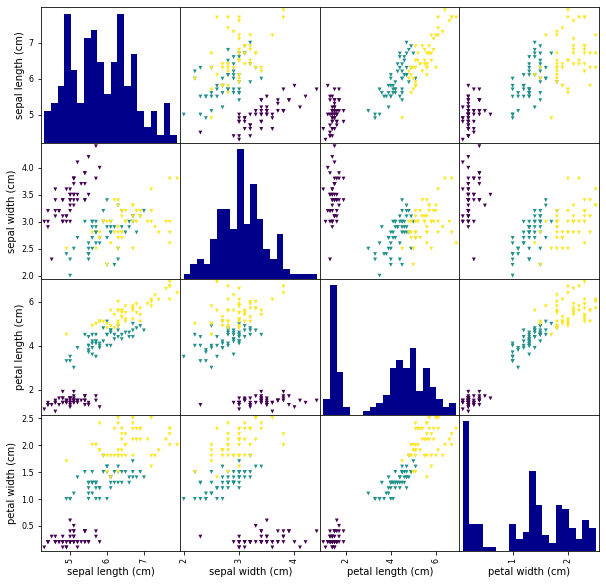

In [12]:
grr = pd.plotting.scatter_matrix(df.iloc[:,:4],c=df['target'], figsize=(10, 10), 
                                 marker='v',hist_kwds={'bins': 20 ,'color':'darkblue'}, s=15, alpha=1)

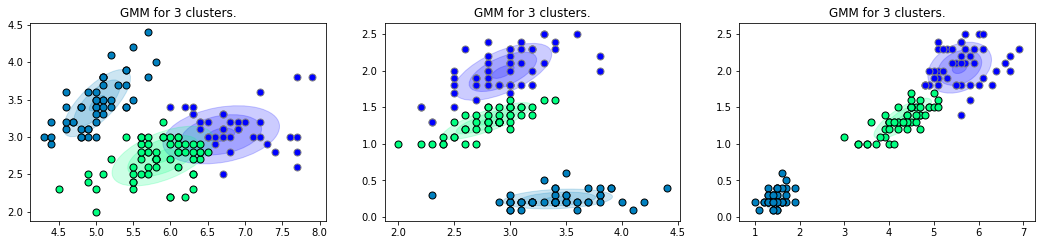

In [23]:
means1,covs1,pi1,label1 = GMM_sklearn_Nd(df.iloc[:,:2],3,100)
means2,covs2,pi2,label2 = GMM_sklearn_Nd(df.iloc[:,[1,3]],3,100)
means3,covs3,pi3,label3 = GMM_sklearn_Nd(df.iloc[:,[2,3]],3,100)
fig = plt.figure(figsize=(18, 8))
for axis,m,c,pi,l,x in zip(range(1,4),[means1,means2,means3],[covs1,covs2,covs3],[pi1,pi2,pi3],[label1,label2,label3],[df.iloc[:,:2],df.iloc[:,[1,3]],df.iloc[:,[2,3]]]):
    ax =  fig.add_subplot(2, 3, axis )
    Gaussian_plot(x,l,m,c,pi,[0.3,0.9,1.3],ax)
    

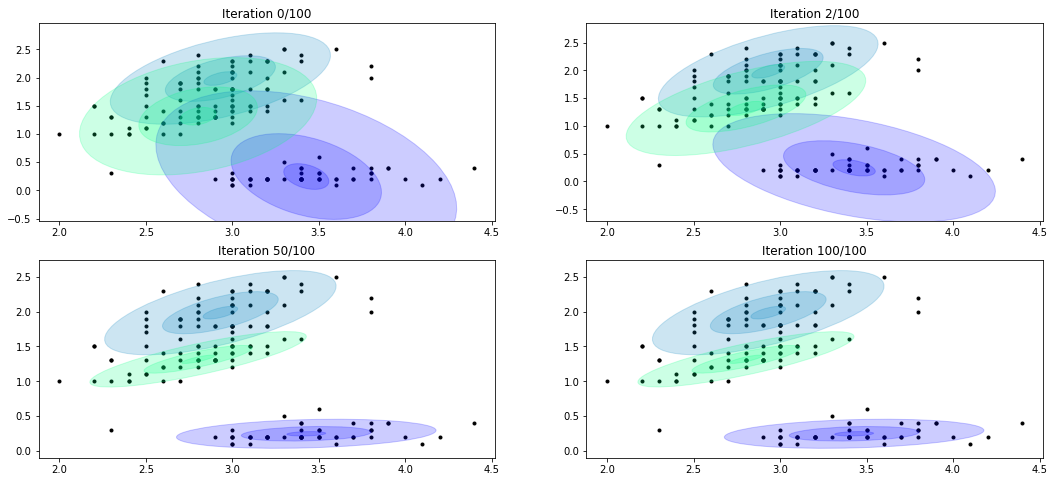

In [57]:
X=np.array(df.iloc[:,[1,3]])
means,covs,log_likelihood,pi = GMM_ND(X,3,101,100,[0.3,1,2])

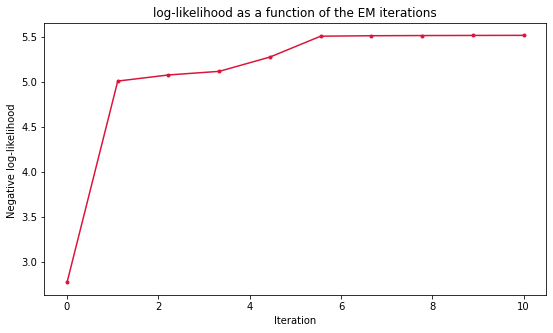

In [26]:
fig = plt.figure(figsize=(9, 5))
x=np.linspace(0,10,len(log_likelihood[:10]))
plt.plot(x,log_likelihood[:10],color='crimson',marker='.')
plt.xlabel('Iteration') ; plt.ylabel('Negative log-likelihood ')
plt.title('log-likelihood as a function of the EM iterations')
plt.show()

##### Prediction and Evaluation

In [29]:
means,covs,pi,prediction = GMM_sklearn_Nd(df.iloc[:,[3,1]],3,100)

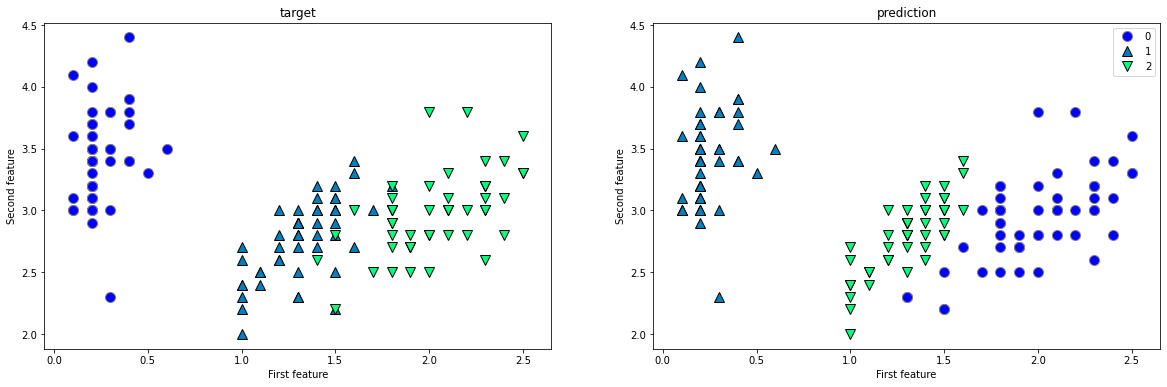

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))  # create subplot with x number of columns
c = cm.winter(np.linspace(0, 1, len(pi))) #colors
for counter,tar,name in zip(range(2),[df['target'],prediction],['target','prediction']):
    mglearn.discrete_scatter(df.iloc[:,3],df.iloc[:,1], tar, ax=ax[counter],c=c)
    plt.legend(["Class 0", "Class 1",'Class 2'], loc=4)
    ax[counter].set_xlabel("First feature")
    ax[counter].set_ylabel("Second feature")
    ax[counter].set_title(name)
plt.legend(loc='upper right')
plt.show()

### 3.1 Online retail data set

In [35]:
path = './OnlineRetail.csv'
df = pd.read_csv(path, delimiter=',', encoding = "ISO-8859-1")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [36]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [39]:
df['Money'] = df['Quantity']*df['UnitPrice']

df1 = df.groupby(by = ['CustomerID'])['Money'].sum().to_frame()

s2 = df.groupby(by  = ['CustomerID'])['InvoiceNo'].count()

df['Date Time']     = pd.to_datetime(df['InvoiceDate'].str.replace('-','/'), format='%d/%m/%Y %H:%M')
Last_DT_Data        = np.max(df['Date Time'])
df['Last Purchase'] = Last_DT_Data - df['Date Time']
Last_P              = df['Last Purchase']
df['Last Purchase'] = Last_P.dt.total_seconds()/60/60/24

s3 = df.groupby(df['CustomerID'])['Last Purchase'].min()

data = pd.concat([df1, s2,s3], axis=1)
data = data.rename({"Money": "Monetary", "InvoiceNo": "Frequency",'Last Purchase':'Recency'}, axis='columns')
data

,Monetary,Frequency,Recency
CustomerID,,,
12346.0,0.00,2,325.106250
12347.0,4310.00,182,1.873611
12348.0,1797.24,31,74.984028
12349.0,1757.55,73,18.124306
12350.0,334.40,17,309.867361
...,...,...,...
18280.0,180.60,10,277.123611
18281.0,80.82,7,180.081250
18282.0,176.60,13,7.046528


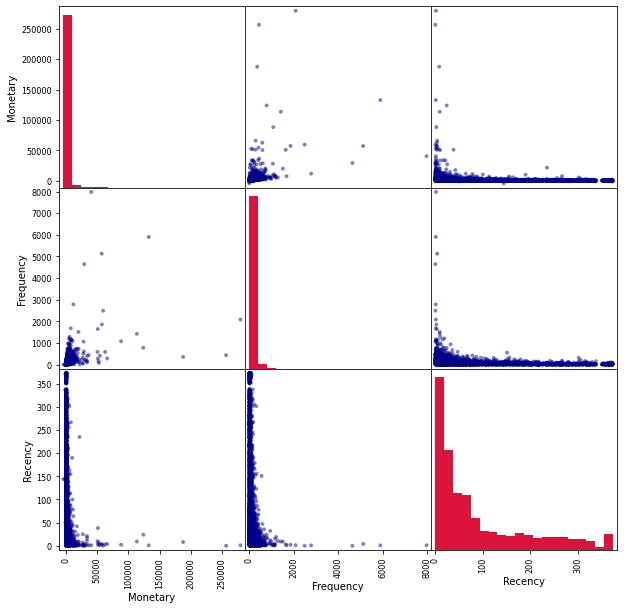

In [41]:
_ = pd.plotting.scatter_matrix(data, figsize=(10, 10), marker='o',
                           hist_kwds={'bins': 20 ,'color':'crimson'}, s=15, alpha=.5,color='darkblue')


Text(0, 0.5, 'Recency')

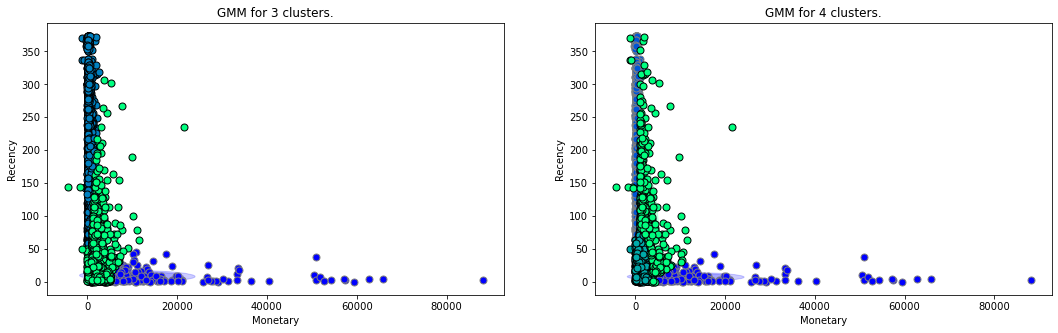

In [43]:
fig = plt.figure(figsize=(18,5))
ax =  fig.add_subplot(111 )

X= data.loc[:,['Monetary','Recency']]
X = X[X['Monetary']<100000 ]
ax =  plt.subplot(1, 2, 1)
means,covs,pi,label = GMM_sklearn_Nd(X,3,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,1],ax)
ax.set_xlabel('Monetary') ; ax.set_ylabel('Recency')
ax =  plt.subplot(1, 2, 2)
means,covs,pi,label = GMM_sklearn_Nd(X,4,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,1],ax)
ax.set_xlabel('Monetary') ; ax.set_ylabel('Recency')

Text(0, 0.5, 'Monetary')

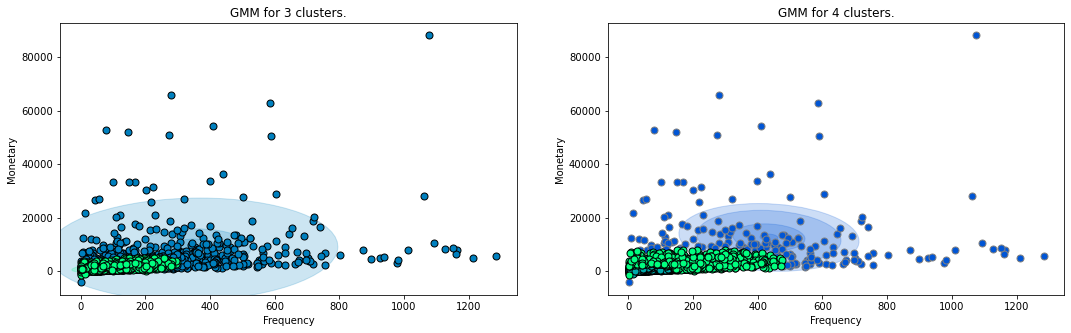

In [44]:
fig = plt.figure(figsize=(18,5))
ax =  fig.add_subplot(111 )

X= data.loc[:,['Frequency','Monetary']]
X = X[X['Frequency']<1500 ]
X = X[X['Monetary']<100000]

ax =  plt.subplot(1, 2, 1)
means,covs,pi,label = GMM_sklearn_Nd(X,3,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,2],ax)
ax.set_xlabel('Frequency') ; ax.set_ylabel('Monetary')
ax =  plt.subplot(1, 2, 2)
means,covs,pi,label = GMM_sklearn_Nd(X,4,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,1],ax)
ax.set_xlabel('Frequency') ; ax.set_ylabel('Monetary')

Text(0, 0.5, 'Recency')

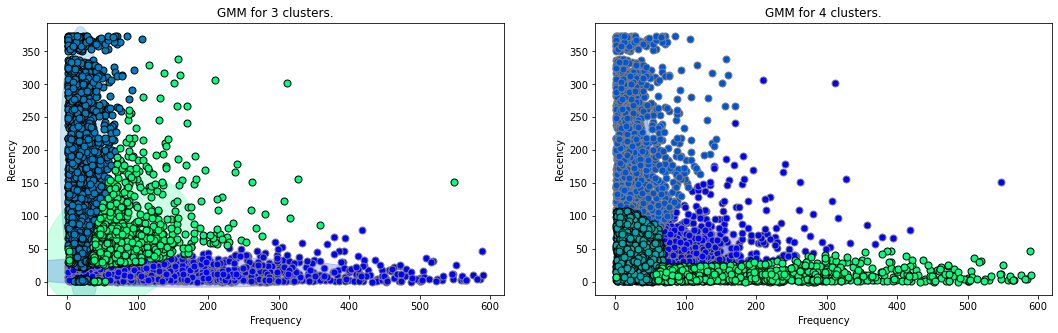

In [45]:
fig = plt.figure(figsize=(18,5))
ax =  fig.add_subplot(111 )

X= data.loc[:,['Frequency','Recency']]
X = X[X['Frequency']<600 ]

ax =  plt.subplot(1, 2, 1)
means,covs,pi,label = GMM_sklearn_Nd(X,3,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,2],ax)
ax.set_xlabel('Frequency') ; ax.set_ylabel('Recency')
ax =  plt.subplot(1, 2, 2)
means,covs,pi,label = GMM_sklearn_Nd(X,4,100)
Gaussian_plot(X,label,means,covs,pi,[0.1,0.4,0.8,1],ax)
ax.set_xlabel('Frequency') ; ax.set_ylabel('Recency')

In [59]:
X = data.loc[:,['Monetary','Recency']].copy()
X.fillna(0,inplace=True)
X.dropna(axis=0,inplace=True)

In [60]:
X.isnull().sum()

Monetary    0
Recency     0
dtype: int64

In [61]:
X = X[X['Monetary']<15000] #Removing the outliners

Text(0, 0.5, 'Recency')

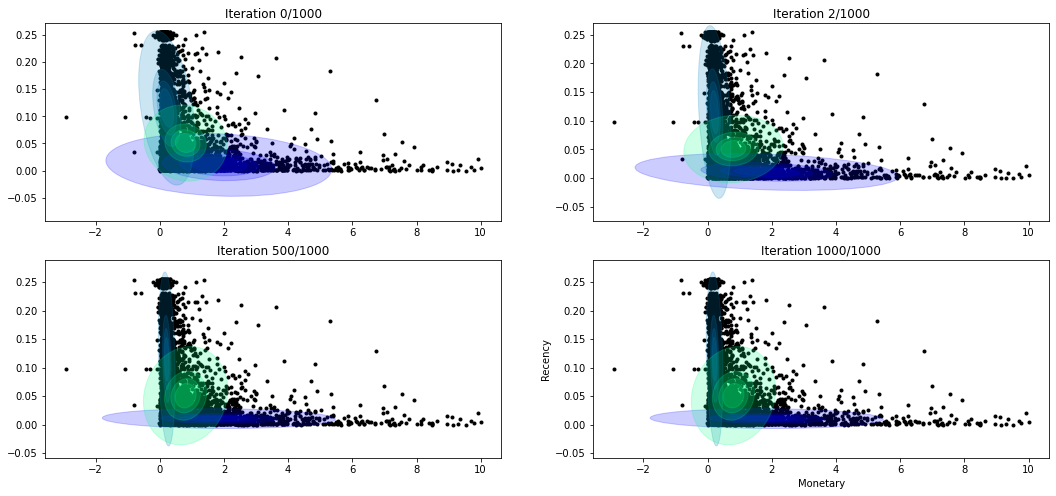

In [63]:
dataa = np.array(X)
means,covs,log_likelihood,pi = GMM_ND(dataa*10/np.max(dataa),3,1001,500,[0.5,0.7,1,2])
plt.xlabel('Monetary') ; plt.ylabel('Recency')

Text(0, 0.5, 'Monetary')

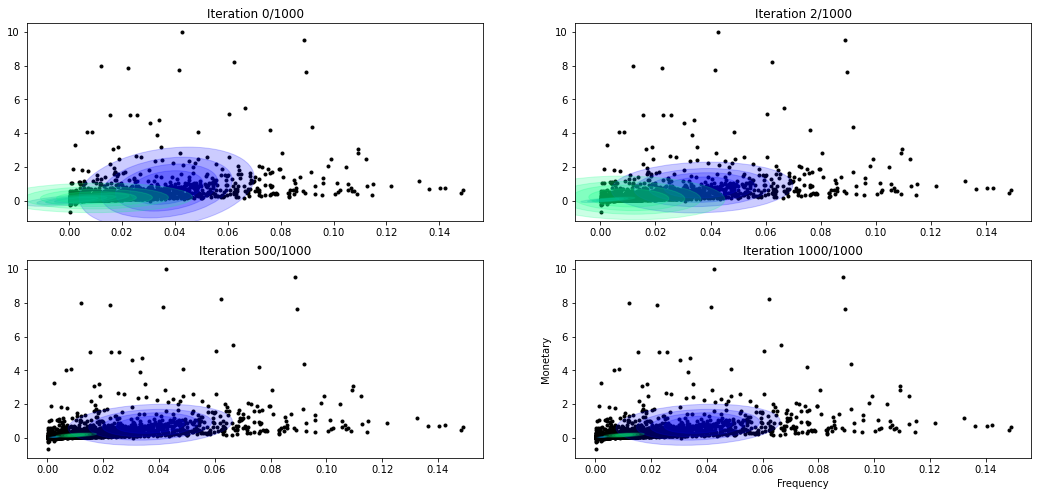

In [71]:
X= data.loc[:,['Frequency','Monetary']]
X = X[X['Frequency']<1000 ]
X = X[X['Monetary']<90000]
X.fillna(0,inplace=True)
X.dropna(axis=0,inplace=True)
dataa = np.array(X)
means,covs,log_likelihood,pi = GMM_ND(dataa*10/np.max(dataa),3,1001,500,[0.5,0.7,0.9,1.2])
plt.xlabel('Frequency') ; plt.ylabel('Monetary')

Text(0, 0.5, 'Recency')

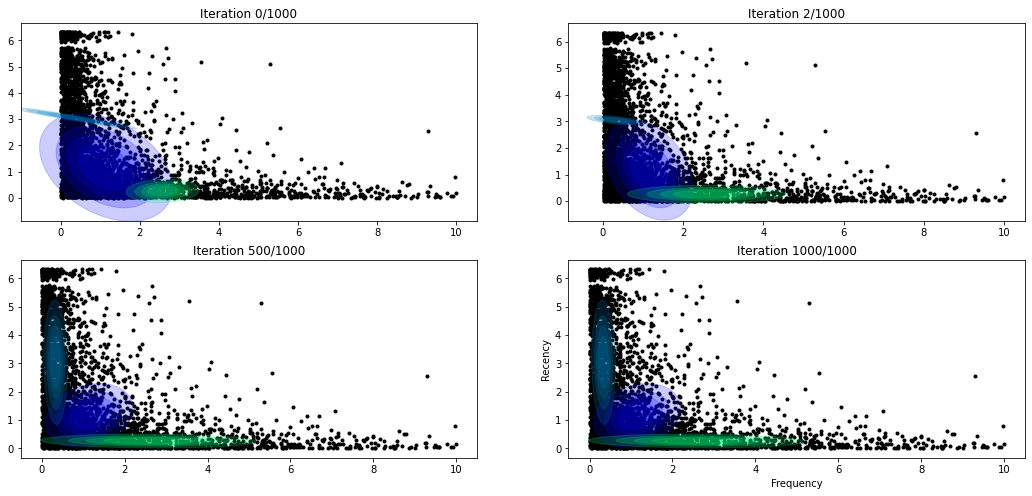

In [73]:
X= data.loc[:,['Frequency','Recency']]
X = X[X['Frequency']<600 ]
X.fillna(0,inplace=True)
X.dropna(axis=0,inplace=True)
dataa = np.array(X)
means,covs,log_likelihood,pi = GMM_ND(dataa*10/np.max(dataa),3,1001,500,[0.5,0.7,0.9,1.2])
plt.xlabel('Frequency') ; plt.ylabel('Recency')